In [1]:
import os
import time
import random
import datetime

import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
slim = tf.contrib.slim

# Training

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
x_size, y_size = 28, 28
n_classes = 10

n_epochs = 1000
ckpt_path = './models/MNIST_NLA_vanilla.ckpt'
variables_file = './variables/scheme1_fr.npz'
activations_file = './variables/scheme1_dr.npz'

def timestamp():
    d = datetime.datetime.now()
    return d.strftime("%Y/%m/%d/%X")

timestamp()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


'2016/12/15/16:53:17'

In [3]:
def random_batch_iterator(x, y, *, batch_size):
    n = x.shape[0]
    assert n == y.shape[0]
    
    while True:
        index = np.random.randint(n, size=batch_size)
        x_batch, y_batch = x[index], y[index]
        yield x_batch.copy(), y_batch.copy()
        
def batch_iterator(x, y, batch_size):
    n = x.shape[0]
    assert n == y.shape[0]
    
    for i in range(0, n, batch_size):
        x_batch, y_batch = x[i:i+batch_size], y[i:i+batch_size]        
        yield x_batch.copy(), y_batch.copy()

In [4]:
def build_cnn(inputs, *, is_training, n_conv, conv_base, conv_mul,
              conv_size, pool_size):
    l = inputs
    for i in range(n_conv):
        n_filters = conv_base * conv_mul ** i
        l = slim.conv2d(l, n_filters, [conv_size, conv_size],
                        scope='conv{}'.format(i+1), is_training=is_training)
        l = slim.max_pool2d(l, [pool_size, pool_size], scope='maxpool{}'.format(i+1), is_training=is_training)
    l = slim.flatten(l)
    
    l = slim.dropout(l, 0.5, scope='dropout', is_training=is_training)
    l = slim.fully_connected(l, 10, activation_fn=None, scope='logits', is_training=is_training)
    return l

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv_layer(prev_layer, C, M, N, scope=''):
    a = tf.Variable(tf.truncated_normal([N,C,M], stddev=0.1), name= scope + "/" + "a")
    s = tf.Variable(tf.truncated_normal([5,5,1,M], stddev=0.1), name= scope + "/" +"basis")
    b = tf.Variable(tf.constant(0.1, shape=[N]), name=scope + "/" +"bias")
    w = []
    for i in range(N):
        temp_w = []
        for c in range(C):
            temp_w_c = []
            for j in range(M):
                temp_w_c.append(a[i,c,j]*s[:,:,:,j])
            temp_w.append(tf.reshape(tf.add_n(temp_w_c), [5,5,1,1]))
        w.append(tf.concat(2, temp_w))
    w = tf.concat(3,w)
    conv1_pred = tf.nn.relu(conv2d(prev_layer, w) + b)
    return conv1_pred,s

def build_mod_cnn(inputs, *, is_training, n_conv, conv_base, conv_mul,
              conv_size, pool_size):
    l = inputs
    input_c [1,32]
    for i in range(n_conv):
        n_filters = conv_base * conv_mul ** i
        l = conv_layer(l, input_c[i], 16, n_filters, scope='conv{}'.format(i+1))[0]
        l = slim.max_pool2d(l, [pool_size, pool_size], scope='maxpool{}'.format(i+1), is_training=is_training)
    l = slim.flatten(l)
    
    l = slim.dropout(l, 0.5, scope='dropout', is_training=is_training)
    l = slim.fully_connected(l, 10, activation_fn=None, scope='logits', is_training=is_training)
    return l

def build_loss(logits, y_true):
    logloss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_true),
                             name='logloss')
    return logloss

In [5]:
batch_size = 512
test_list = list(batch_iterator(
        mnist.test.images, mnist.test.labels, batch_size=batch_size))

n_conv = 2
conv_base = 32
conv_mul = 2
conv_size = 5
pool_size = 2

def build_model(graph, build_cnn):
    with graph.as_default():#, graph.device('/cpu:0'):
        with tf.variable_scope('model') as vs:
            is_training = tf.placeholder(tf.bool)
            x_ph = tf.placeholder(tf.float32, shape=[batch_size, x_size * y_size])
            x_image = tf.reshape(x_ph, [-1, x_size, y_size, 1])
            y_ph = tf.placeholder(tf.int64, shape=[batch_size])

            logits = build_mod_cnn(x_image, is_training=is_training, n_conv=n_conv,
                               conv_base=conv_base, conv_mul=conv_mul,
                               conv_size=conv_size, pool_size=pool_size)

            prediction = tf.nn.softmax(logits, name='predictions')

            loss = build_loss(logits, y_ph)

            optimizer = tf.train.AdamOptimizer().minimize(loss, name='optimizer')

            correct_prediction = tf.equal(tf.argmax(prediction, 1), y_ph)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

        # Code to use of tensorboard
        with tf.name_scope('summaries'):
            tf.scalar_summary('log_loss', loss)
            tf.scalar_summary('acc', accuracy)
            merged_summary = tf.merge_all_summaries()
            
    return {
        'is_training': is_training,
        'x_ph': x_ph,
        'y_ph': y_ph,
        'prediction': prediction,
        'loss': loss,
        'optimizer': optimizer,
        'accuracy': accuracy,
        'merged_summary': merged_summary
    }

In [6]:
def train_net(layers, session, *, n_epochs, ckpt_path, tb_path='/tmp/tf/', ckpt=None):
    tb_path = tb_path + timestamp()
    
    l = layers
    x_ph, y_ph, is_training = l['x_ph'], l['y_ph'], l['is_training']
    val_operations = [l['merged_summary'], l['accuracy'], l['loss']]
    train_operations = [l['optimizer']] + val_operations

    train_iterator = random_batch_iterator(
        mnist.train.images, mnist.train.labels, batch_size=batch_size)
    val_iterator = random_batch_iterator(
        mnist.validation.images, mnist.validation.labels, batch_size=batch_size)
        
    train_writer = tf.train.SummaryWriter(tb_path+'/train', session.graph)
    val_writer = tf.train.SummaryWriter(tb_path+'/val', session.graph)
    saver = tf.train.Saver()

    best_acc = 0.0
    if ckpt:
        variables_to_restore = slim.get_variables_to_restore(exclude=["conv1", "conv2"])
        restore = tf.train.Saver(variables_to_restore)
        restore.restore(session, ckpt)
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        x_batch, y_batch = next(train_iterator)
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: True}
        _, summary, acc, _ = session.run(train_operations, feed_dict)
        train_writer.add_summary(summary, epoch)

        x_batch, y_batch = next(val_iterator)
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: False}
        summary, acc, _ = session.run(val_operations, feed_dict)
        val_writer.add_summary(summary, epoch)

    saver.save(session, ckpt_path)
                
    return best_acc

def evaluate_net(layers, session):
    l = layers
    x_ph, y_ph, is_training = l['x_ph'], l['y_ph'], l['is_training']
    
    test_iterator = iter(test_list)
    
    n, test_acc = 0, 0.0
    start = time.time()
    for x_batch, y_batch in test_iterator:
        if len(x_batch) != batch_size:
            break
        feed_dict = {x_ph: x_batch, y_ph: y_batch, is_training: False}
        test_acc += l['accuracy'].eval(feed_dict=feed_dict)
        n += 1
    end = time.time()
    test_acc = test_acc / n
    return test_acc, end-start

In [7]:
graph = tf.Graph()
layers = build_model(graph, build_cnn)
with tf.Session(graph=graph) as session:
    train_net(layers, session, n_epochs=n_epochs, ckpt_path=ckpt_path, ckpt=None)###Change THIS!!!
    test_acc, els = evaluate_net(layers, session)

test_acc, els

(0.99187911184210531, 0.14334893226623535)

## Saving weights

In [8]:
with tf.Session(graph=graph) as session:
    restorer = tf.train.Saver()
    restorer.restore(session, ckpt_path)
    conv_vars = {}
    for i in range(n_conv):
        for name in ['weights', 'bias']:
            full_name = 'conv{}/{}'.format(i+1, name)
            conv_vars[full_name] = slim.get_variables(scope='model/'+full_name)[0].eval()
            
np.savez(variables_file, **conv_vars)

In [9]:
np.load(variables_file).keys()

['conv1/weights', 'conv2/bias', 'conv2/weights', 'conv1/bias']

In [11]:
n_measurements = 100

with tf.Session(graph=graph) as session:
    restorer = tf.train.Saver()
    restorer.restore(session, ckpt_path)
    mesurements = []
    for i in range(n_measurements):
        test_acc, els = evaluate_net(layers, session)
        mesurements.append(els)

(array([  0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   3.,   4.,   5.,
          4.,   8.,  10.,  15.,  17.,   8.,  12.,   4.,   2.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.]),
 array([ 0.135   ,  0.135375,  0.13575 ,  0.136125,  0.1365  ,  0.136875,
         0.13725 ,  0.137625,  0.138   ,  0.138375,  0.13875 ,  0.139125,
         0.1395  ,  0.139875,  0.14025 ,  0.140625,  0.141   ,  0.141375,
         0.14175 ,  0.142125,  0.1425  ,  0.142875,  0.14325 ,  0.143625,
         0.144   ,  0.144375,  0.14475 ,  0.145125,  0.1455  ,  0.145875,
         0.14625 ,  0.146625,  0.147   ,  0.147375,  0.14775 ,  0.148125,
         0.1485  ,  0.148875,  0.14925 ,  0.149625,  0.15    ]),
 <a list of 40 Patch objects>)

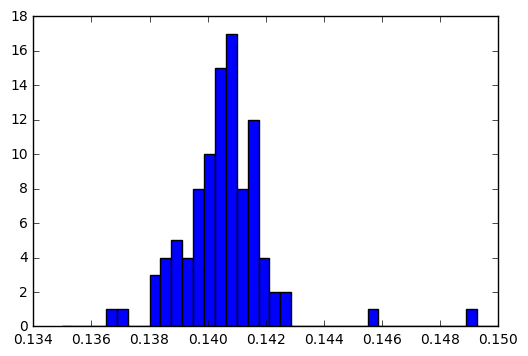

In [13]:
plt.hist(mesurements, bins=40, range=(0.135, 0.15))